In [289]:
import plotly.graph_objects as go
# import kaleido
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
import numpy as np
import json

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# local modules 
import sys
sys.path.insert(0, "../scripts")
import helpers as h
import seaborn as sns

import matplotlib.pyplot as plt

from numpy.linalg import lstsq
import scipy.signal

import scipy.optimize

In [207]:
a00, a01 = h.import_desired_data("A", "15T")
a00.set_index(a00["DateTime"].values, inplace=True)

amb = a01["Ambient Temp"]
# a01.set_index(time.values, inplace=True)
print(a00["Window Open"].unique(), a01["Window Open"].unique(), a00.columns)


[1.] [0. 1.] Index(['DateTime', 'Temp C', 'RH %', 'Room', 'Ambient Temp', 'Ambient RH',
       'Window Open'],
      dtype='object')


In [386]:
amb.std

<bound method NDFrame._add_numeric_operations.<locals>.std of 2022-07-20 07:15:00    0.222591
2022-07-20 07:30:00    0.222591
2022-07-20 07:45:00    0.222591
2022-07-20 08:00:00    0.242525
2022-07-20 08:15:00    0.242525
                         ...   
2022-07-24 06:15:00    0.239203
2022-07-24 06:30:00    0.239203
2022-07-24 06:45:00    0.239203
2022-07-24 07:00:00    0.245847
2022-07-24 07:15:00    0.245847
Name: Ambient Temp, Length: 385, dtype: float64>

## Testing Guesses

In [84]:
def make_fit(series, A, w, phi, w_t_var):
    n = len(series)
    t = np.arange(n)

    w_t = np.random.normal(0, 1, size=w_t_var)
    x_t = A*np.cos(2*np.pi*w*t + phi) # + w_t

    return x_t, t

In [85]:
def norm_grad(series):
    return h.normalize(np.gradient(series))

In [217]:
peaks=scipy.signal.find_peaks(ddt_dif_xt)
peaks[01]

array([  3,   7,  19,  26,  28,  32,  38,  44,  51,  57,  62,  67,  72,
        79,  86,  93,  96, 104, 108, 114, 118, 124, 128, 131, 136, 141,
       144, 146, 150, 152, 160, 162, 175, 187, 193, 197, 201, 207, 220,
       224, 229, 231, 235, 241, 245, 249, 253, 256, 260, 265, 268, 288,
       293, 305, 307, 310, 316, 323, 330, 335, 344, 351, 353, 357, 367,
       380])

3     2022-07-20 08:00:00
7     2022-07-20 09:00:00
19    2022-07-20 12:00:00
26    2022-07-20 13:45:00
28    2022-07-20 14:15:00
              ...        
351   2022-07-23 23:00:00
353   2022-07-23 23:30:00
357   2022-07-24 00:30:00
367   2022-07-24 03:00:00
380   2022-07-24 06:15:00
Name: DateTime, Length: 66, dtype: datetime64[ns]

In [278]:
big_peak = f_ddt_sort[0]
big_peak


1.1544011544011544e-05

In [279]:
3.9*(1/(len(temp)))

0.01012987012987013

In [292]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"

    # https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    
    '''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [384]:
temp = a01["Temp C"]
time = a01["DateTime"]

# normalized temperature 
norm_temp = h.normalize(temp)


# fit an optimal sinusoid 
xt_res = fit_sin(freqdf["Time"], norm_temp)
xt = h.normalize(xt_res["fitfunc"](freqdf["Time"]))

xt2 = xt.apply(lambda x: 0.5 if x < 0.5 else x)
xt3 = norm_temp.ewm(4).mean()
# temp.ewcm

# difference and derivative 
dif_xt = h.normalize(norm_temp - xt3)

# fit sin to the differnce 
dif_xt_res = fit_sin(freqdf["Time"], dif_xt)
dif_xt_sin = h.normalize(dif_xt_res["fitfunc"](freqdf["Time"]))

ddt_dif_xt= norm_grad(dif_xt)

smooth_dif_xt

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time, y=a01["Window Open"], name="Window", mode='lines',
))

fig.add_trace(go.Scatter(x=time, y=norm_temp, name="Indoor Temp, Normalized", mode='lines',))

fig.add_trace(go.Scatter(x=time, y=xt, name="xt", mode='lines',))

fig.add_trace(go.Scatter(x=time, y=xt3, name="xt3", mode='lines',))

fig.add_trace(go.Scatter(x=time, y=dif_xt, name="dif_xt", mode='lines',))

# fig.add_trace(go.Scatter(x=time, y=dif_xt_sin, name="dif_xt_sin", mode='lines',))

fig.add_trace(go.Scatter(x=time, y=ddt_dif_xt, name="Window Detection", mode='lines',))





AttributeError: 'numpy.ndarray' object has no attribute 'ewm'

In [376]:
temp.ewm(4).mean()

0      23.438600
1      23.427044
2      23.422272
3      23.466828
4      23.525779
         ...    
380    23.440309
381    23.426688
382    23.412910
383    23.401888
384    23.394350
Name: Temp C, Length: 385, dtype: float64

In [371]:
xt.apply(lambda x: x + 0.2)

0      0.320254
1      0.342591
2      0.366491
3      0.391851
4      0.418558
         ...   
380    0.322085
381    0.344559
382    0.368587
383    0.394065
384    0.420882
Name: Time, Length: 385, dtype: float64

In [372]:
xt.apply(lambda x: x+0.2 if x < 0.5 else x)

0      0.320254
1      0.342591
2      0.366491
3      0.391851
4      0.418558
         ...   
380    0.322085
381    0.344559
382    0.368587
383    0.394065
384    0.420882
Name: Time, Length: 385, dtype: float64

In [ ]:
xt2 = [i + (0.5 - i ) for i in xt if i < 0.5]
xt2

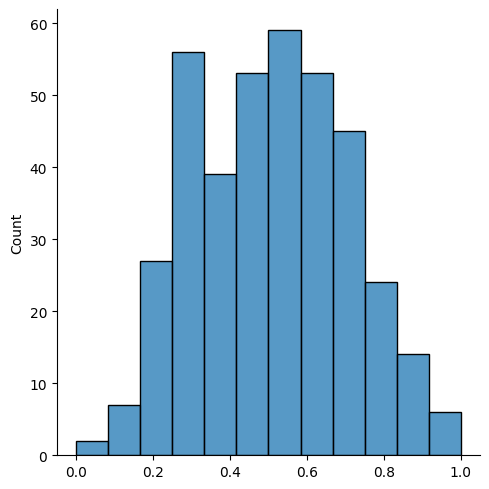

In [312]:
sns.displot(ddt_dif_xt)

In [310]:


# sinusoidal fit to normalized temp (eyeballing )
xt, t = make_fit(series=temp, A=-0.5, w=3.9*(1/(len(temp))), phi=0.8, w_t_var=1)
xt += 0.5

xt, t = make_fit(series=temp, A=-0.5, w=big_peak, phi=0.8, w_t_var=1)


# difference and derivative 
dif_xt = norm_temp - xt 
ddt_dif_xt= norm_grad(dif_xt)

# ambient temp 
amb = h.normalize(a00["Ambient Temp"])

peaks=scipy.signal.find_peaks(ddt_dif_xt, prominence=0.2)[0]
peak_widths = scipy.signal.peak_widths(ddt_dif_xt, peaks)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time, y=a01["Window Open"], name="Window", mode='lines',
))

fig.add_trace(go.Scatter(x=time, y=norm_temp, name="Indoor Temp, Normalized", mode='lines',))

# fig.add_trace(go.Scatter(x=time, y=xt, name="xt", mode='lines',))

fig.add_trace(go.Scatter(x=time, y=ddt_dif_xt, name="Window Detection", mode='lines',))

# fig.add_trace(go.Scatter( x=time, y=amb,  name="Ambient", mode='lines',))

# fig.add_trace(go.Scatter( x=time[peaks], y=ddt_dif_xt[peaks],  name="peaks", mode='markers',))





In [260]:
peak_widths_sort = np.sort(peak_widths[0])
peak_widths_sort_ix = np.argsort(peak_widths[0])

peak_widths_sort_small = peak_widths_sort[0:15]
peak_widths_sort_ix_small = peak_widths_sort_ix[0:15]

peak_widths_sort_small

array([ 2.04645277,  2.54211675,  2.72590287,  3.97991012,  5.31452752,
        6.70245734,  7.42524233,  7.42734758, 10.81124454, 11.1244649 ,
       11.29995622, 12.3494428 , 23.31855652, 23.84605508, 25.15284034])

In [271]:
peak_widths[0]

array([10.81124454,  7.42524233, 23.31855652,  6.70245734, 11.1244649 ,
       23.84605508,  3.97991012,  2.72590287,  2.04645277,  2.54211675,
       25.15284034,  5.31452752, 12.3494428 , 11.29995622,  7.42734758])

In [273]:
time[peaks]

7     2022-07-20 09:00:00
44    2022-07-20 18:15:00
62    2022-07-20 22:45:00
104   2022-07-21 09:15:00
136   2022-07-21 17:15:00
160   2022-07-21 23:15:00
193   2022-07-22 07:30:00
197   2022-07-22 08:30:00
207   2022-07-22 11:00:00
224   2022-07-22 15:15:00
256   2022-07-22 23:15:00
293   2022-07-23 08:30:00
335   2022-07-23 19:00:00
351   2022-07-23 23:00:00
367   2022-07-24 03:00:00
Name: DateTime, dtype: datetime64[ns]

In [275]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time[peaks],  y=peak_widths[0], name="Peak widths", mode='lines+markers',
))

# fig.add_trace(go.Scatter(x=time, y=norm_temp, name="norm_temp", mode='lines',))

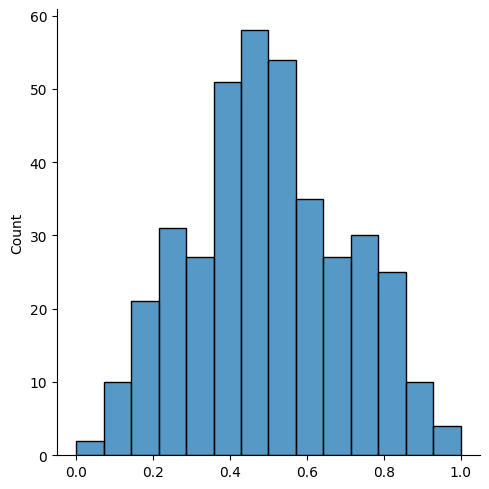

In [242]:
sns.displot(ddt_dif_xt)

## Frequency analysis 
http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/t7a_time_series.html

In [87]:
freqdf = a01.filter(["DateTime", "Temp C"], axis=1)
freqdf = freqdf.reset_index(drop=True)
freqdf["ddt_dif_xt"] = ddt_dif_xt

# sampling rate 
inter_sample_time = freqdf["DateTime"][1] - freqdf["DateTime"][0]
print('inter_sample_time =', inter_sample_time.total_seconds(), 's')

freqdf["Time"] = freqdf["DateTime"] - freqdf["DateTime"].min()
freqdf["Time"] = freqdf["Time"].dt.total_seconds()


freqdf

inter_sample_time = 900.0 s


,DateTime,Temp C,ddt_dif_xt,Time
0,2022-07-20 07:15:00,23.4386,0.165671,0.0
1,2022-07-20 07:30:00,23.4178,0.202032,900.0
2,2022-07-20 07:45:00,23.4154,0.561096,1800.0
3,2022-07-20 08:00:00,23.5538,0.814707,2700.0
4,2022-07-20 08:15:00,23.6650,0.783955,3600.0
...,...,...,...,...
380,2022-07-24 06:15:00,23.3738,0.502745,342000.0
381,2022-07-24 06:30:00,23.3722,0.488154,342900.0
382,2022-07-24 06:45:00,23.3578,0.471588,343800.0
383,2022-07-24 07:00:00,23.3578,0.499834,344700.0


In [88]:
inter_sample_time = freqdf["Time"][1] - freqdf["Time"][0]
print('inter_sample_time =', inter_sample_time, 's')

# # Check to make sure they are all the same
print('All the same?:', np.allclose(np.diff(freqdf["Time"]), inter_sample_time))

n_samples = len(freqdf)
sampling_freq = 1/inter_sample_time 

print(f"n_samples: {n_samples}, sampling_freq: {sampling_freq}")

inter_sample_time = 900.0 s
All the same?: True
n_samples: 385, sampling_freq: 0.0011111111111111111


In [89]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=freqdf["Time"],
#     y=freqdf["Temp C"], 
#     name="Window",
#     mode='lines',
# ))


In [104]:
f_ddt, psd_ddt = scipy.signal.periodogram(freqdf["ddt_dif_xt"], fs=sampling_freq)

f_temp, psd_temp = scipy.signal.periodogram(freqdf["Temp C"], fs=sampling_freq)


In [287]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=f_temp,
    y=psd_temp, 
    name="Indoor Temperature ",
    mode='lines',
))

# fig.update_yaxes(type="log")


fig.add_trace(go.Scatter(
    x=f_ddt,
    y=psd_ddt, 
    name="Window Detection",
    mode='lines',
))

In [112]:
psd_ddt_sort_ix = np.argsort(psd_ddt)[::-1]
f_ddt_sort = f_ddt[psd_ddt_sort_ix]
print(f_ddt_sort[0:5])

psd_ddt_sort_ix[0:10]

[1.15440115e-05 3.46320346e-05 5.77200577e-05 8.65800866e-06
 5.77200577e-06]


array([ 4, 12, 20,  3,  2,  7, 19, 16, 15, 23])

In [169]:
big_peak = 1/f_ddt_sort[0]

inter_sample_time # 15 mins 
day_length = inter_sample_time* 4 * 24
day_length_freq = 1/ day_length
day_length_2 = (inter_sample_time* 4 * 24 ) + 900

print(big_peak, day_length, day_length_2, day_length_freq )

86625.0 86400.0 87300.0 1.1574074074074073e-05


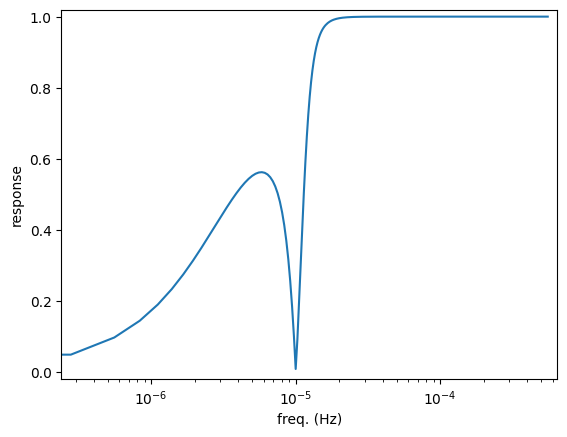

In [198]:
b, a = scipy.signal.cheby2(3, 5,  day_length_freq / nyquist_freq, btype='high')

# Get frequency response curve
w, hf = scipy.signal.freqz(b, a, worN=2000)

# Make plot
plt.semilogx((nyquist_freq / np.pi) * w, abs(hf))
plt.xlabel('freq. (Hz)')
plt.ylabel('response')
plt.margins(0.02)

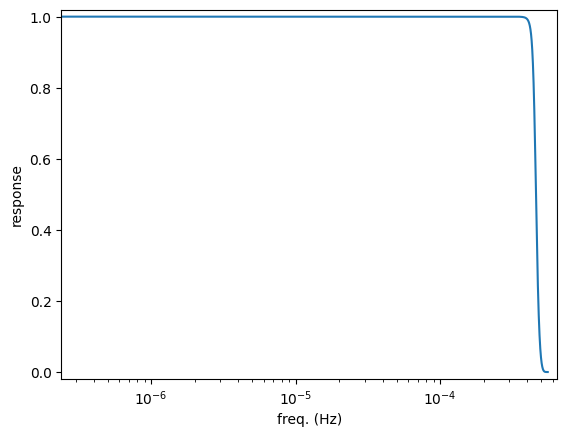

In [357]:
nyquist_freq = sampling_freq / 2
nyquist_freq


# Design a butterworth filter
b, a = scipy.signal.butter(5, 4.5e-4/ nyquist_freq, btype='low')

# b2, a2 = scipy.signal.cheby1(3, 1.16e-5 / nyquist_freq, btype='high')

# Get frequency response curve
w, hf = scipy.signal.freqz(b, a, worN=2000)

# Make plot
plt.semilogx((nyquist_freq / np.pi) * w, abs(hf))
plt.xlabel('freq. (Hz)')
plt.ylabel('response')
plt.margins(0.02)

In [358]:
freqdf["filtered temp"] = scipy.signal.lfilter(b, a, freqdf["Temp C"])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=freqdf["Time"], y=a01["Window Open"], name="Window", mode='lines',
))


fig.add_trace(go.Scatter(
    x=freqdf["Time"],
    y=h.normalize(freqdf["Temp C"]), 
    name="temp",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=freqdf["Time"],
    y=h.normalize(freqdf["filtered temp"]), 
    name="filtered",
    mode='lines',
))

dif = h.normalize(freqdf["Temp C"]) -  h.normalize(freqdf["filtered temp"])

fig.add_trace(go.Scatter(
    x=freqdf["Time"], y=dif, name="dif", mode='lines',
))




In [199]:
freqdf["filted ddt"] = scipy.signal.lfilter(b, a, freqdf["ddt_dif_xt"])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=freqdf["Time"], y=a01["Window Open"], name="Window", mode='lines',
))


fig.add_trace(go.Scatter(
    x=freqdf["Time"],
    y=freqdf["ddt_dif_xt"], 
    name="ddt",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=freqdf["Time"],
    y=h.normalize(freqdf["filted ddt"]), 
    name="filtered",
    mode='lines',
))


In [200]:

f_ddt2, psd_ddt2 = scipy.signal.periodogram(h.normalize(freqdf["filted ddt"]), fs=sampling_freq)

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=f_ddt,
    y=psd_ddt, 
    name="DDT",
    mode='lines',
))



fig.add_trace(go.Scatter(
    x=f_ddt2,
    y=psd_ddt2, 
    name="ddt post filter",
    mode='lines',
))



## Autocorrelation 

In [25]:
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

<AxesSubplot:xlabel='LAG', ylabel='ACF'>

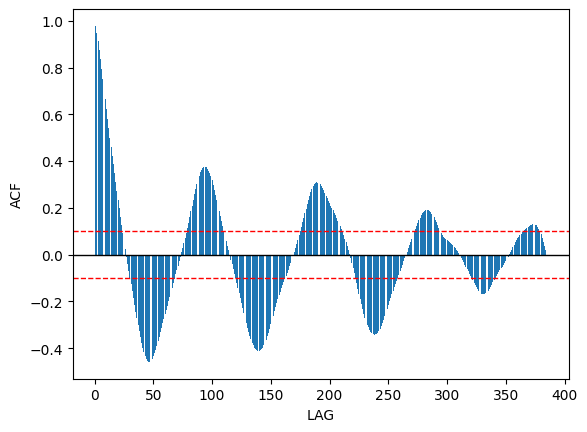

In [26]:
acf1(a01["Temp C"], nlags = (len(a01["Temp C"])-1))

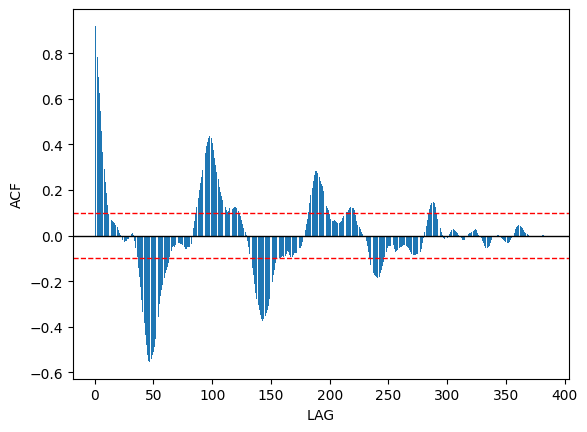

In [27]:
corr_array = acf1(pd.Series(ddt_dif_xt), nlags = (len(a01["Temp C"])-1))